In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib # Import the matplotlib library to access __version__

In [2]:
print('Numpy Version',np.__version__)
print('Pandas Version',pd.__version__)
print('Seaborn Version',sns.__version__)
print('Matplotlib Version',matplotlib.__version__) # Now you can access matplotlib.__version__

Numpy Version 2.0.2
Pandas Version 2.2.2
Seaborn Version 0.13.2
Matplotlib Version 3.10.0


In [3]:
df = pd.read_csv('world_population.csv')

In [4]:
# Inspect the column names in the uploaded dataset
#df.columns.tolist()


In [5]:
# Create a standard country-to-continent mapping using pycountry_convert
!pip install pycountry-convert --quiet
import pycountry_convert as pc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.0/244.0 kB 16.3 MB/s eta 0:00:00


In [6]:
# Function to map country to continent
def get_continent(country):
    try:
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        return pc.convert_continent_code_to_continent_name(continent_code)
    except:
        return None #return None if the country is not found in the cloud database

In [7]:
# Apply the mapping
df['Continent'] = df['Country Name'].apply(get_continent)

In [8]:
# Clean dataset again now with continent
df_clean = df.dropna(subset=['Continent', 'Country Name'])

In [9]:
# Year columns and grouping logic
year_columns = [col for col in df_clean.columns if col.isdigit()]
year_columns = sorted(year_columns)
year_columns_int = list(map(int, year_columns))

interval = 3 #Interval for every 3 years
period = 4
groups = []
start_year = min(year_columns_int)
end_year = max(year_columns_int)

while start_year + period - 1 <= end_year:
    group_years = [str(year) for year in range(start_year, start_year + period)]
    groups.append((f"{start_year}-{start_year + period - 1}", group_years))
    start_year += interval


In [10]:
# Compute average population for each group
continent_country_avg = df_clean[["Continent", "Country Name"]].copy()

for label, years in groups:
    valid_years = [year for year in years if year in df_clean.columns]
    continent_country_avg[label] = df_clean[valid_years].mean(axis=1)


In [11]:
# Identify max per period and continent
continent_group_max = []

for label, _ in groups:
    for continent in df_clean["Continent"].dropna().unique():
        sub_df = continent_country_avg[continent_country_avg["Continent"] == continent]
        if label in sub_df.columns and sub_df[label].notna().any():
            max_row = sub_df.loc[sub_df[label].idxmax()]
            continent_group_max.append({
                "Period": label,
                "Continent": continent,
                "Country Name": max_row["Country Name"],
                "Average Population": max_row[label]
            })

df_max = pd.DataFrame(continent_group_max)

In [12]:
# Find country with most appearances as max
top_country = df_max['Country Name'].value_counts().idxmax()


In [13]:
# Ext#ract its population trend
country_data = df_clean[df_clean["Country Name"] == top_country]
country_population_trend = country_data[year_columns].T
country_population_trend.columns = [top_country]
country_population_trend.index.name = "Year"


In [30]:
#Here's the corrected version of your code with a minor adjustment for consistency. Since you're using a file path, it's a good practice to add r to the string to treat it as a raw string and avoid escape sequence issues. Here's the updated code:
#output_excel_path = r'C:\Users\nsfut\Downloads\New folder\output.xlsx' # added r for raw string

output_excel_path = 'WP_Visuals_Continents.xlsx' # added r for raw string
with pd.ExcelWriter(output_excel_path) as writer:
    df_max.to_excel(writer, sheet_name="Max by Period & Continent", index=False)
    country_population_trend.to_excel(writer, sheet_name=f"{top_country} Trend", index=False)  # Ensure index=False for consistency

#print(output_excel_path)  # Print the path to confirm


In [15]:
df_clean.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,Continent
0,Aruba,ABW,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,307.972222,312.366667,314.983333,316.827778,318.666667,...,563.011111,563.422222,564.427778,566.311111,568.850000,571.783333,574.672222,577.161111,NaN,North America
1,Andorra,AND,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,30.587234,32.714894,34.914894,37.170213,39.470213,...,182.161702,181.859574,179.614894,175.161702,168.757447,161.493617,154.863830,149.942553,NaN,Europe
2,Afghanistan,AFG,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,14.038148,14.312061,14.599692,14.901579,15.218206,...,40.634655,41.674005,42.830327,44.127634,45.533197,46.997059,48.444546,49.821649,NaN,Asia
3,Angola,AGO,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,4.305195,4.384299,4.464433,4.544558,4.624228,...,15.915819,16.459536,17.020898,17.600302,18.196544,18.808215,19.433323,20.070565,NaN,Africa
4,Albania,ALB,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,60.576642,62.456898,64.329234,66.209307,68.058066,...,107.566204,106.843759,106.314635,106.013869,105.848431,105.717226,105.607810,105.444051,NaN,Europe


In [28]:
pd.options.display.max_rows = None

In [29]:
pd.set_option('display.max_rows', None)  # Set the maximum number of rows to display to unlimited
pd.set_option('display.max_columns', None)  # Set the maximum number of columns to display to unlimited
display(df_clean)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,Continent
0,Aruba,ABW,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,307.972222,312.366667,314.983333,316.827778,318.666667,320.622222,322.494444,324.361111,326.244444,328.138889,330.211111,332.494444,334.661111,336.250000,336.972222,336.605556,335.366667,333.922222,333.211111,333.866667,336.483333,340.800000,345.577778,349.061111,350.155556,348.022222,343.527778,339.316667,339.066667,345.266667,359.016667,379.083333,402.766667,426.111111,446.255556,462.194444,474.705556,484.866667,494.466667,504.766667,516.077778,527.750000,538.972222,548.566667,555.727778,560.166667,562.322222,563.011111,563.422222,564.427778,566.311111,568.850000,571.783333,574.672222,577.161111,NaN,North America
1,Andorra,AND,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,30.587234,32.714894,34.914894,37.170213,39.470213,41.800000,44.159574,46.570213,49.065957,51.657447,54.382979,57.217021,60.065957,62.795745,65.331915,67.619149,69.721277,71.800000,74.082979,76.729787,79.791489,83.217021,86.940426,90.859574,94.887234,98.968085,103.102128,107.300000,111.593617,115.980851,120.582979,125.327660,129.793617,133.419149,135.859574,136.789362,136.482979,135.931915,136.512766,139.146809,144.191489,151.161702,159.112766,166.674468,172.814894,177.389362,180.591489,182.161702,181.859574,179.614894,175.161702,168.757447,161.493617,154.863830,149.942553,NaN,Europe
2,Afghanistan,AFG,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,14.038148,14.312061,14.599692,14.901579,15.218206,15.545203,15.881812,16.235931,16.618433,17.034429,17.481269,17.947027,18.415149,18.864003,19.273587,19.654077,19.998926,20.253266,20.346290,20.236210,19.907672,19.402324,18.808159,18.246653,17.814689,17.521289,17.366559,17.424514,17.780766,18.484162,19.589765,21.054483,22.706815,24.308377,25.690840,26.777257,27.623273,28.354440,29.161566,30.177894,31.448029,32.912231,34.475030,35.995236,37.373936,38.574296,39.637202,40.634655,41.674005,42.830327,44.127634,45.533197,46.997059,48.444546,49.821649,NaN,Asia
3,Angola,AGO,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,4.305195,4.384299,4.464433,4.544558,4.624228,4.703271,4.782892,4.865721,4.955244,5.054118,5.163748,5.284068,5.414466,5.553661,5.700918,5.855064,6.016941,6.190053,6.379147,6.586950,6.816355,7.064660,7.322255,7.575935,7.816804,8.040186,8.250351,8.458253,8.679708,8.925860,9.202032,9.504268,9.823362,10.145571,10.461752,10.768279,11.070721,11.380212,11.712507,12.078798,12.483188,12.921871,13.388462,13.873025,14.368286,14.872437,15.387749,15.915819,16.459536,17.020898,17.600302,18.196544,18.808215,19.433323,20.070565,NaN,Africa
4,Albania,ALB,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,60.576642,62.456898,64.329234,66.209307,68.058066,69.874927,71.737153,73.805547,75.974270,77.937190,79.848650,81.865912,83.823066,85.770949,87.767555,89.727226,91.735255,93.659343,95.541314,97.518139,99.491095,101.615985,103.794161,106.001058,108.202993,110.315146,112.540328,114.683796,117.808139,119.946788,119.225912,118.505073,117.784197,117.063358,116.342482,115.621642,114.900766,114.179927,113.459051,112.738212,111.685146,111.350730,110.934891,110.472226,109.908285,109.217044,108.394781,107.566204,106.843759,106.314635,106.013869,105.848431,105.717226,105.607810,105.444051,NaN,Europe
6,United Arab Emirates,ARE,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,1.207955,1.342584,1.497799,1.653349,1.798062,1.926758,2.054797,2.216651,2.458971,2.816196,3.291388,3.876423,4.579222,5.406077,6.354844,7.440801,8.646519,9.897057,11.092141,12.162548,13.075455,13.857380,14.572045,15.314330,16.153505,17.111818,18.169749,19.3050

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    264 non-null    object 
 1   Country Code    264 non-null    object 
 2   Indicator Name  264 non-null    object 
 3   Indicator Code  264 non-null    object 
 4   1960            0 non-null      float64
 5   1961            253 non-null    float64
 6   1962            253 non-null    float64
 7   1963            253 non-null    float64
 8   1964            253 non-null    float64
 9   1965            253 non-null    float64
 10  1966            253 non-null    float64
 11  1967            253 non-null    float64
 12  1968            253 non-null    float64
 13  1969            253 non-null    float64
 14  1970            253 non-null    float64
 15  1971            253 non-null    float64
 16  1972            253 non-null    float64
 17  1973            253 non-null    flo

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
1960,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961,253.0,176.915141,943.335678,0.098625,10.550711,26.403402,86.646634,11406.000000
1962,253.0,180.703231,962.152018,0.102429,10.832306,26.888150,87.879176,11521.000000
1963,253.0,184.572413,981.766557,0.106526,11.078952,27.521085,89.023222,11584.500000
1964,253.0,188.461797,1002.141213,0.110038,11.329188,28.428442,89.965509,11618.500000
1965,253.0,192.412363,1023.607719,0.114721,11.582654,29.373887,90.872827,11641.500000
1966,253.0,196.145042,1045.338502,0.118525,11.839337,30.358488,91.718628,11652.000000
1967,253.0,200.118063,1068.523145,0.122622,12.098215,31.114555,92.973684,11648.500000
1968,253.0,203.879464,1090.949797,0.127012,12.356687,31.752903,94.871324,11856.450000
1969,253.0,207.336102,1110.937670,0.131402,12.737931,32.385777,95.712623,12265.500000


In [20]:
df.isnull().sum()

,0
Country Name,0
Country Code,0
Indicator Name,0
Indicator Code,0
1960,264
1961,11
1962,11
1963,11
1964,11
1965,11


In [21]:
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
5,False
6,False
7,False
8,False
9,False


In [27]:
# Assuming 'df' is your DataFrame and 'column_name' is the column want to check

# Get the index of rows where the specified column is blank/null
blank_cell_indices = df[df['Continent'].isnull()].index.tolist()

# Print the list of blank cell indices
print("Blank cells in column 'Continent' are at indices:", blank_cell_indices)

# If you want to display the entire rows with blank cells:
blank_rows = df[df['Continent'].isnull()]
print("\nRows with blank cells in column 'Continent':\n", blank_rows)

Blank cells in column 'Continent' are at indices: [5, 21, 34, 36, 39, 41, 46, 48, 58, 59, 60, 61, 62, 64, 65, 70, 71, 76, 83, 92, 93, 95, 99, 100, 101, 102, 104, 107, 109, 123, 124, 126, 127, 132, 133, 134, 137, 138, 140, 144, 145, 151, 154, 155, 159, 168, 179, 181, 189, 191, 194, 195, 201, 212, 214, 215, 222, 227, 228, 233, 234, 235, 237, 238, 246, 250, 251, 253, 256, 257, 259, 261]

Rows with blank cells in column 'Continent':
                                           Country Name Country Code  \
5                                           Arab World          ARB   
21                                        Bahamas, The          BHS   
34                      Central Europe and the Baltics          CEB   
36                                     Channel Islands          CHI   
39                                       Cote d'Ivoire          CIV   
41                                         Congo, Rep.          COG   
46                              Caribbean small states          CSS  

In [23]:
from ast import Name
# Assuming 'df' is your DataFrame

# Filter rows with blank cells in the 'Continent' column
blank_continent_rows = df[df['Continent'].isnull()]

# Print or display the filtered DataFrame
from ast import Name
# Assuming 'df' is your DataFrame

# Filter rows with blank cells in the 'Continent' column
blank_continent_rows = df[df['Continent'].isnull()]

# Print or display the filtered DataFrame
#print(blank_continent_rows)  # Print the filtered rows
# or
display(blank_continent_rows) # Display the filtered rows (if using Jupyter Notebook or similar)
#ascending=Country Name  # This line is not valid Python and should be removed or corrected depending on your intent

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,Continent
5,Arab World,ARB,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,6.978698,7.171974,7.372223,7.579523,7.793882,8.016037,8.245913,8.481858,8.721638,8.964173,9.207193,9.453972,9.710734,9.985656,10.284389,10.609376,10.958335,11.325895,11.704050,12.086819,12.472603,12.862438,13.256491,13.652808,14.060803,14.474624,14.889317,15.307283,15.725975,16.303395,16.747738,17.059385,17.515316,17.975134,18.540138,18.968215,19.388853,19.802924,20.221913,20.649297,21.087169,21.535696,22.000563,22.489096,23.006077,23.554705,24.131584,24.727571,25.331750,25.923338,26.504736,27.075214,27.640621,28.207253,28.779858,NaN,None
21,"Bahamas, The",BHS,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,11.499301,12.096204,12.720380,13.356344,13.990909,14.621778,15.245455,15.847053,16.408591,16.918681,17.369331,17.766633,18.130769,18.491209,18.869331,19.271229,19.692108,20.130969,20.583217,21.044955,21.518881,22.005495,22.496004,22.978621,23.444955,23.889311,24.314785,24.732867,25.160340,25.608192,26.085614,26.586713,27.089411,27.562737,27.987113,28.350849,28.668132,28.976424,29.327872,29.759341,30.283516,30.886114,31.544156,32.221678,32.891409,33.546553,34.191708,34.823876,35.442557,36.046953,36.634466,37.201598,37.746354,38.267133,38.763137,NaN,None
34,Central Europe and the Baltics,CEB,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,83.398088,84.102848,84.853332,85.646161,86.301988,86.937125,87.747130,88.506382,89.157185,89.638272,90.096339,90.751555,91.435985,92.182640,93.011123,93.833538,94.573420,95.219087,95.784515,96.364179,96.928489,97.456399,97.960163,98.436084,98.894669,99.334930,99.741442,100.096701,100.288534,100.238191,99.816139,99.558378,99.627904,99.567384,99.472935,99.147099,99.057465,98.830408,98.725916,98.110227,97.572655,97.101591,96.810769,96.544264,96.307480,96.078625,95.639681,95.298460,95.030293,94.682093,94.344988,94.144992,93.943337,93.746284,93.585469,NaN,None
36,Channel Islands,CHI,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,569.067010,574.551546,580.386598,586.484536,592.742268,599.103093,605.541237,611.989691,618.407216,624.721649,630.994845,637.170103,642.927835,647.835052,651.634021,654.154639,655.618557,656.670103,658.216495,660.891753,664.886598,670.015464,676.072165,682.737113,689.711340,697.046392,704.721649,712.298969,719.216495,725.097938,729.731959,733.288660,736.195876,739.113402,742.525773,746.556701,751.077320,756.025773,761.247423,766.623711,772.149485,777.860825,783.680412,789.536082,795.350515,801.108247,806.783505,812.304124,817.592784,839.910526,844.678947,849.136842,853.357895,857.457895,861.536842,NaN,None
39,Cote d'Ivoire,CIV,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,11.327280,11.762588,12.232261,12.734827,13.269619,13.836648,14.437855,15.076726,15.757742,16.484006,17.256585,18.074318,18.935236,19.836277,20.774827,21.749377,22.759280,23.803642,24.881730,25.992292,27.135601,28.309434,29.507198,30.720456,31.943500,33.170277,34.402475,35.651327,36.933013,38.257575,39.625682,41.028009,42.451874,43.879808,45.296667,46.705009,48.101855,49.460635,50.747874,51.943233,53.035774,54.042204,55.004840,55.982755,57.021075,58.133308,59.315006,60.571217,61.902230,63.307255,64.792994,66.360506,67.995252,69.676437,71.388541,NaN,None
41,"Congo, Rep.",COG,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,3.045288,3.126240,3.210840,3.298981,3.390644,3.485684,3.584307,3.687233,3.795423,3.909488,4.029836,4.156091,4.287122,4.421318,4.557558,4.695303,4.834946,4.977397,5.124038,5.275807,5.433063,5.595315,5.761628,5.930659,6.101458,6.273877,6.448334,6.625171,6.804949,6.988190,7

In [26]:
blank_continent_rows.to_excel('Coutries with no Continents.xlsx', index=False)

In [26]:
df1=df_clean.head()

<ipython-input-31-94d04453c218>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


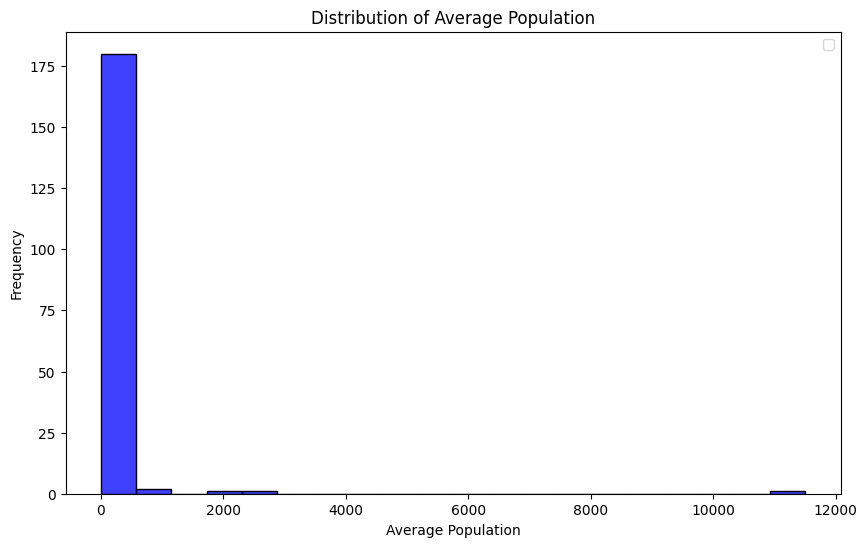

In [31]:
plt.figure(figsize=(10, 6))
# Access the correct column from continent_country_avg instead of df1
sns.histplot(continent_country_avg['1960-1963'], bins=20, color='blue')
plt.title('Distribution of Average Population')
plt.xlabel('Average Population')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

<ipython-input-32-9d256c79aab6>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


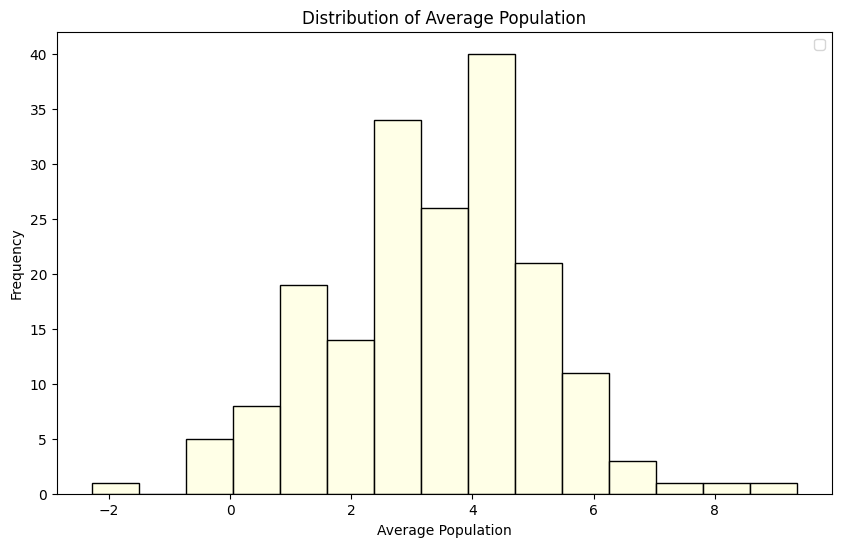

In [32]:
plt.figure(figsize=(10, 6))
# Access the correct column from continent_country_avg instead of df1
sns.histplot(np.log(continent_country_avg["1960-1963"]), bins=15, color='lightyellow')
plt.title('Distribution of Average Population')
plt.xlabel('Average Population')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

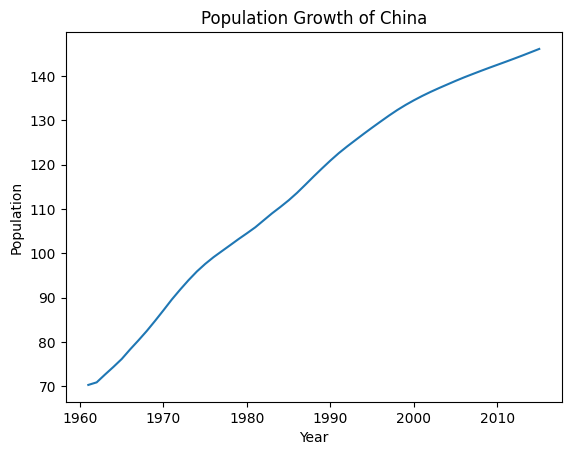

In [37]:
df_target = df_clean[df_clean['Country Name'] == 'China'] # Replace 'China' with your desired target country
plt.plot(year_columns_int, df_target[year_columns].values[0]) # Use year_columns_int for x-axis and extract population values
plt.title(f'Population Growth of China') # Update title accordingly
plt.xlabel('Year')
plt.ylabel('Population')
plt.show()

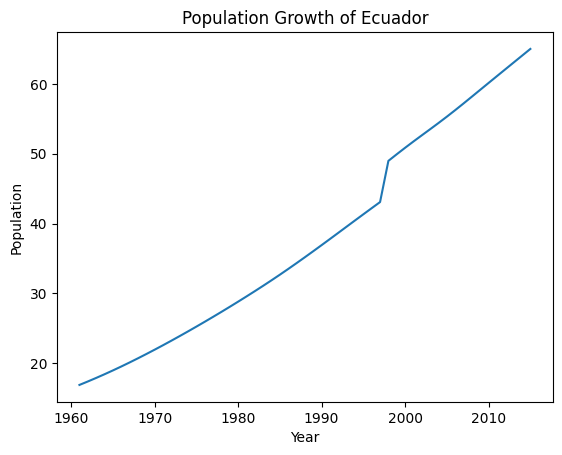

In [39]:
df_target = df_clean[df_clean['Country Name'] == 'Ecuador'] # Replace 'China' with your desired target country
plt.plot(year_columns_int, df_target[year_columns].values[0]) # Use year_columns_int for x-axis and extract population values
plt.title(f'Population Growth of Ecuador') # Update title accordingly
plt.xlabel('Year')
plt.ylabel('Population')
plt.show()

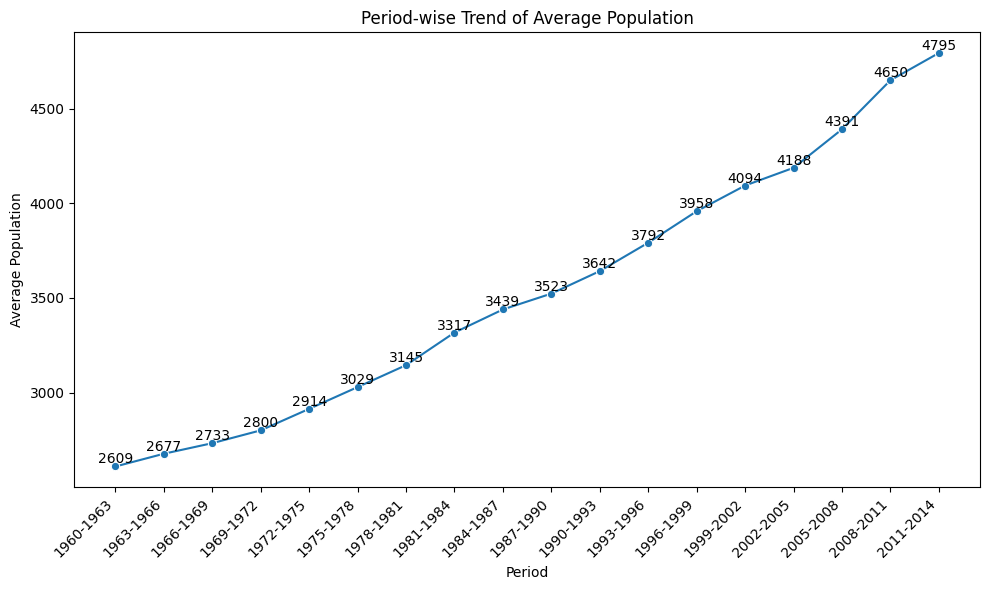

In [47]:
# Assuming df_max contains 'Period' and 'Average Population' columns
# Extract the periods and average populations
periods = df_max['Period'].unique()
avg_populations = []

for period in periods:
    avg_pop = df_max[df_max['Period'] == period]['Average Population'].mean()
    avg_populations.append(avg_pop)

# Create the trend line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=periods, y=avg_populations, marker='o')
plt.title('Period-wise Trend of Average Population')
plt.xlabel('Period')
plt.ylabel('Average Population')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Add labels to each point
for i, period in enumerate(periods):
    plt.text(period, avg_populations[i], f"{avg_populations[i]:.0f}", ha='center', va='bottom')

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

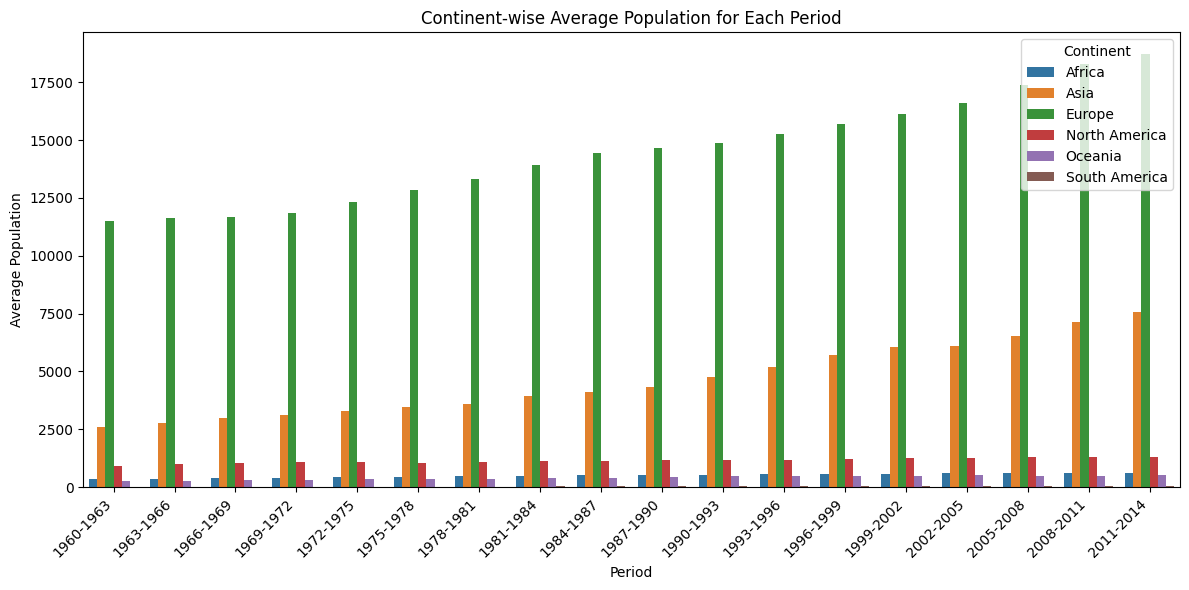

In [48]:
# Assuming df_max contains 'Period', 'Continent', and 'Average Population' columns

# Group data by period and continent, calculating average population
period_continent_avg = df_max.groupby(['Period', 'Continent'])['Average Population'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Period', y='Average Population', hue='Continent', data=period_continent_avg)
plt.title('Continent-wise Average Population for Each Period')
plt.xlabel('Period')
plt.ylabel('Average Population')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.legend(title='Continent', loc='upper right')  # Add legend for continents
plt.show()

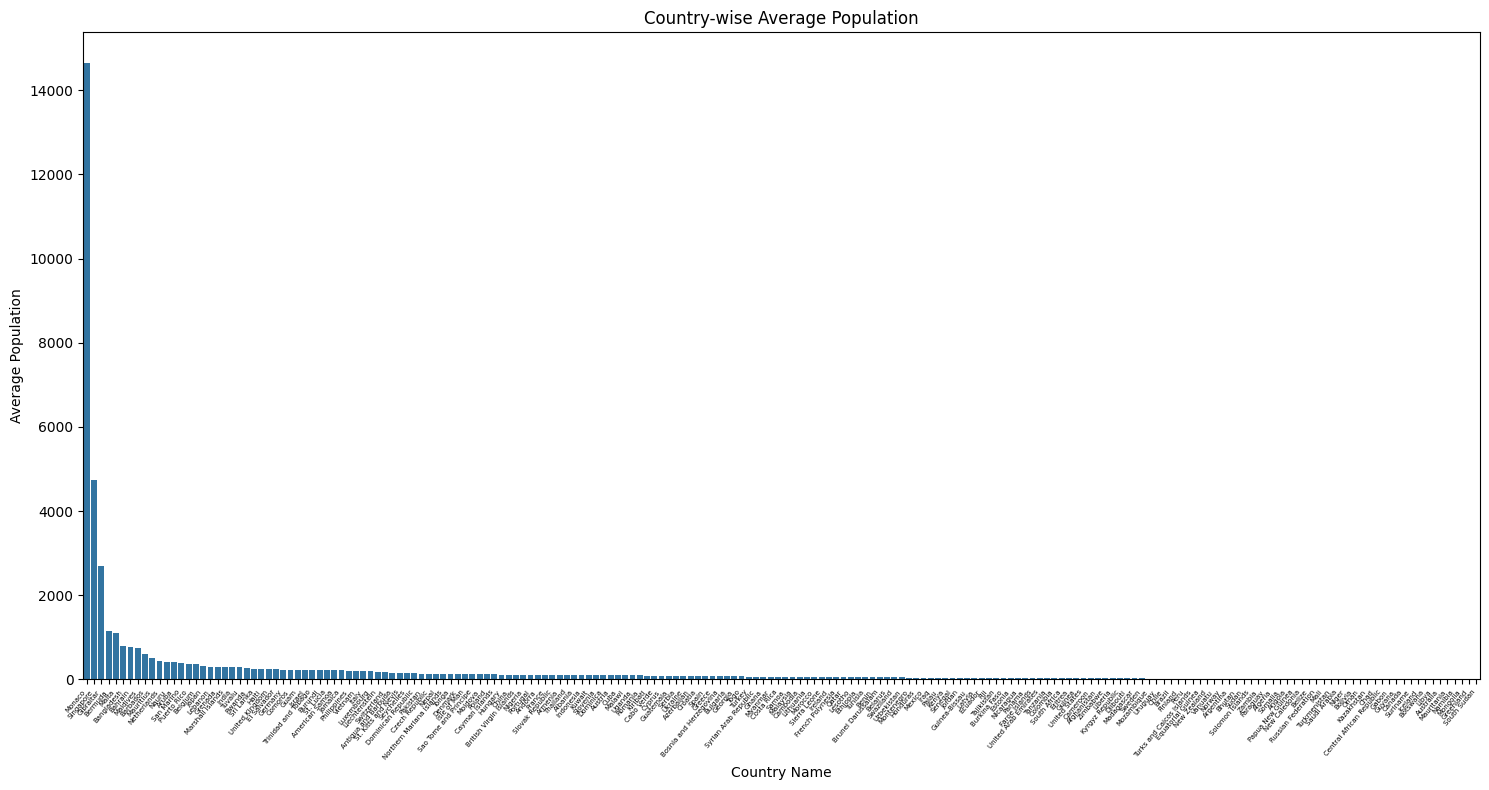

In [49]:
# Assuming 'df_clean' contains 'Country Name' and year columns

# Calculate average population for each country
country_avg_population = df_clean.groupby('Country Name')[year_columns].mean().mean(axis=1)

# Sort countries by average population in descending order
country_avg_population = country_avg_population.sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(15, 8))  # Adjust figure size as needed
sns.barplot(x=country_avg_population.index, y=country_avg_population.values)
plt.title('Country-wise Average Population')
plt.xlabel('Country Name')
plt.ylabel('Average Population')
plt.xticks(rotation=50, ha='right', fontsize=5)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

<ipython-input-50-85a6aee68702>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_10_countries.index, y=top_10_countries.values, palette=colors)


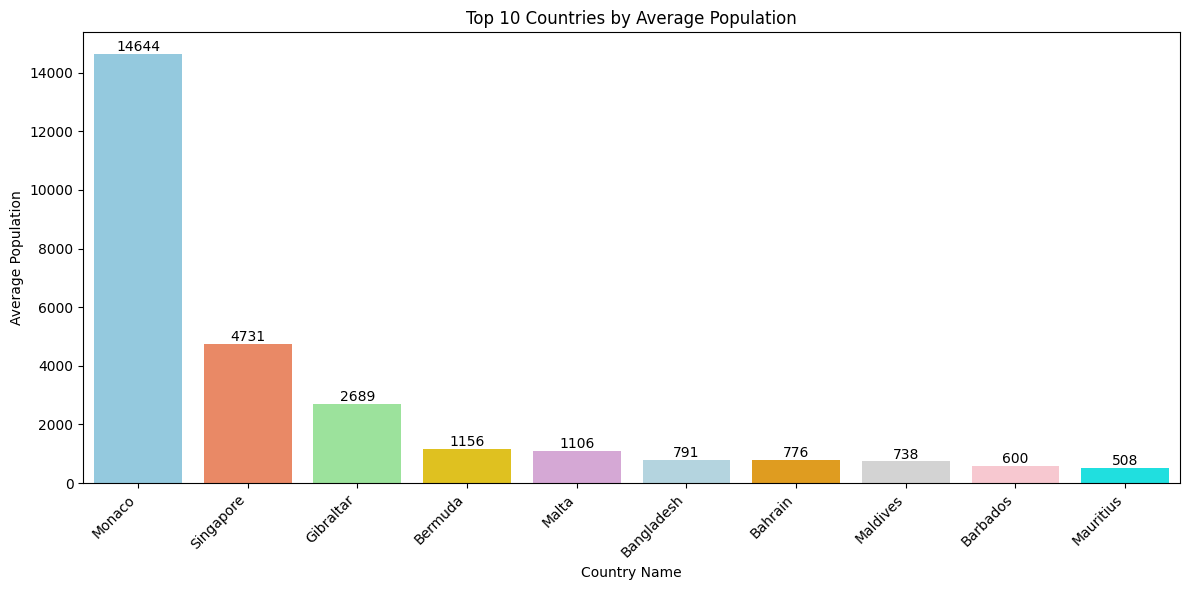

In [50]:
# Assuming 'df_clean' contains 'Country Name' and year columns

# 1. Calculate Average Population for each country
country_avg_population = df_clean.groupby('Country Name')[year_columns].mean().mean(axis=1)

# 2. Get Top 10 Countries by Average Population
top_10_countries = country_avg_population.sort_values(ascending=False).head(10)

# 3. Define Colors for Bars
colors = ['skyblue', 'coral', 'lightgreen', 'gold', 'plum', 'lightblue', 'orange', 'lightgrey', 'pink', 'cyan']

# 4. Create Bar Plot with Different Colors and Labels
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_10_countries.index, y=top_10_countries.values, palette=colors)
plt.title('Top 10 Countries by Average Population')
plt.xlabel('Country Name')
plt.ylabel('Average Population')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Add labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 5),
                   textcoords='offset points')

plt.tight_layout()
plt.show()

<ipython-input-51-11c975a391e1>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_5_continents.index, y=top_5_continents.values, palette=colors)


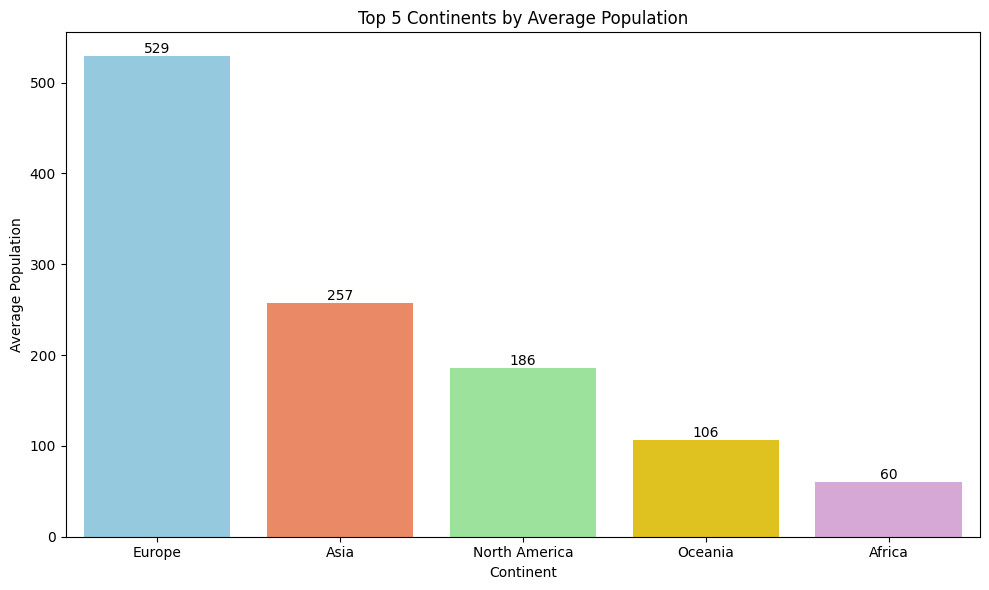

In [51]:
# Assuming 'df_clean' contains 'Continent' and year columns

# 1. Calculate Average Population for each continent
continent_avg_population = df_clean.groupby('Continent')[year_columns].mean().mean(axis=1)

# 2. Get Top 5 Continents by Average Population
top_5_continents = continent_avg_population.sort_values(ascending=False).head(5)

# 3. Create Bar Plot with Different Colors
plt.figure(figsize=(10, 6))
colors = ['skyblue', 'coral', 'lightgreen', 'gold', 'plum']  # Define colors for each bar
ax = sns.barplot(x=top_5_continents.index, y=top_5_continents.values, palette=colors)
plt.title('Top 5 Continents by Average Population')
plt.xlabel('Continent')
plt.ylabel('Average Population')

# Add labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 5),
                   textcoords='offset points')

plt.tight_layout()
plt.show()

In [52]:

# Assuming 'df' is your DataFrame with 'Continent' and 'Country Name' columns

# Group by continent and count the number of countries
continent_country_counts = df.groupby('Continent')['Country Name'].nunique()

# Print or display the results
print("Continent-wise Country Counts:\n", continent_country_counts)  # Print to console
# or
#display(continent_country_counts)  # Display in Jupyter Notebook

# Get the total number of countries
total_countries = continent_country_counts.sum()

# Get the total number of continents
total_continents = len(continent_country_counts)  # Get the number of unique continents

print("\nTotal number of countries:", total_countries)
print("Total number of continents:", total_continents)

Continent-wise Country Counts:
 Continent
Africa           49
Asia             41
Europe           45
North America    28
Oceania          18
South America    11
Name: Country Name, dtype: int64

Total number of countries: 192
Total number of continents: 6
